<a href="https://colab.research.google.com/github/arnimpdm/Covid-19-prediction/blob/master/Covid19_pred_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost
!pip install pmdarima
!pip install pycountry
!pip install pycountry_convert

     |████████████████████████████████| 66.1MB 55kB/s 
     |████████████████████████████████| 1.5MB 3.4MB/s 
     |████████████████████████████████| 8.7MB 19.0MB/s 
     |████████████████████████████████| 808kB 42.9MB/s 
     |████████████████████████████████| 2.1MB 42.7MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: setuptools 50.3.0
    Uninstalling setuptools-50.3.0:
      Successfully uninstalled setuptools-50.3.0
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


     |████████████████████████████████| 10.1MB 3.4MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746865 sha256=634f6b4b7153858233aa63a82e52c3a92b80727de4280896f5edfa89de414080
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
Successfully built pycountry
     |████████████████████████████████| 235kB 6.8MB/s 
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 5.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 5.3 which is incompatible.
ERROR: pytest-mock 3.3.1 has requirement pytest>=5.0, but you'll have pytest 3.6.4 which is incompatible.
ERROR: pytest-cov 2.10.1 has requirement pytest>=4.6, but you'll have pytest 3.6.4 which is incompatible.
  Found existing installation: coverage 3.7.1


In [110]:
from catboost import CatBoostRegressor
from datetime import datetime, timedelta
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from matplotlib import pyplot
from matplotlib.pylab import rcParams
from pandas import DataFrame
from pmdarima.arima import auto_arima, ARIMA
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, explained_variance_score, mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from statistics import mean
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from time import sleep
from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import trange, tqdm, tnrange
from xgboost import plot_importance, plot_tree, XGBClassifier
from xgboost.sklearn import XGBClassifier
from IPython.display import clear_output
from google.colab import drive
import datetime as dt
import getpass
import graphviz
import hyperopt
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pmdarima as pm
import pycountry
import pycountry_convert as pc
import pydotplus
import seaborn as sns
import sklearn.linear_model as lm
import statsmodels.api as sm
import warnings
import xgboost as xgb
pd.options.display.float_format = '{:.2f}'.format   
pd.plotting.register_matplotlib_converters()
rcParams['figure.figsize'] = 15, 5
warnings.filterwarnings('ignore')

## Data load

In [111]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df = pd.read_csv(url)
df = pd.melt(df, id_vars=['Province/State', 'Country/Region','Lat','Long'], var_name='Date', value_name='Confirmed')
df['Date'] = pd.to_datetime(df['Date'])
df.head(5)

,Province/State,Country/Region,Lat,Long,Date,Confirmed
0,NaN,Afghanistan,33.94,67.71,2020-01-22,0
1,NaN,Albania,41.15,20.17,2020-01-22,0
2,NaN,Algeria,28.03,1.66,2020-01-22,0
3,NaN,Andorra,42.51,1.52,2020-01-22,0
4,NaN,Angola,-11.20,17.87,2020-01-22,0


In [112]:
max(df.Date)

Timestamp('2020-09-18 00:00:00')

In [113]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64106 entries, 0 to 64105
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province/State  19521 non-null  object        
 1   Country/Region  64106 non-null  object        
 2   Lat             64106 non-null  float64       
 3   Long            64106 non-null  float64       
 4   Date            64106 non-null  datetime64[ns]
 5   Confirmed       64106 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 2.9+ MB


In [114]:
df = df.rename(columns={'Province/State': 'Province', 'Country/Region': 'Country'})
df.shape

(64106, 6)

In [115]:
df_worldwide = pd.DataFrame(df.groupby('Date')['Confirmed'].sum())
df_worldwide['Date'] = df_worldwide.index
df_worldwide = df_worldwide.reset_index(drop=True)
df_worldwide['Country'] = 'Worldwide'
df = df.append(df_worldwide)

In [116]:
df_missing_countries = df.copy()
df_missing_countries = df_missing_countries.dropna(subset=['Province'])
df_missing_countries = pd.DataFrame(df_missing_countries.groupby(['Date','Country'])['Confirmed'].sum())
df_missing_countries.reset_index(inplace=True)  
df = df.append(df_missing_countries)

In [117]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv'
df_country = pd.read_csv(url)
df_country = df_country.drop_duplicates(subset=['Country_Region'], keep='first')
df_country

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population
0,4,AF,AFG,4.00,nan,NaN,NaN,Afghanistan,33.94,67.71,Afghanistan,38928341.00
1,8,AL,ALB,8.00,nan,NaN,NaN,Albania,41.15,20.17,Albania,2877800.00
2,12,DZ,DZA,12.00,nan,NaN,NaN,Algeria,28.03,1.66,Algeria,43851043.00
3,20,AD,AND,20.00,nan,NaN,NaN,Andorra,42.51,1.52,Andorra,77265.00
4,24,AO,AGO,24.00,nan,NaN,NaN,Angola,-11.20,17.87,Angola,32866268.00
...,...,...,...,...,...,...,...,...,...,...,...,...
689,716,ZW,ZWE,716.00,nan,NaN,NaN,Zimbabwe,-19.02,29.15,Zimbabwe,14862927.00
690,36,AU,AUS,36.00,nan,NaN,NaN,Australia,-25.00,133.00,Australia,25459700.00
699,124,CA,CAN,124.00,nan,NaN,NaN,Canada,60.00,-95.00,Canada,37855702.00
715,156,CN,CHN,156.00,nan,NaN,NaN,China,30.59,114.31,China,1404676330.00


In [118]:
# apply the mapping to df
df = pd.merge(df, df_country[['Country_Region','iso2']], left_on='Country', right_on='Country_Region', how='left')
df

,Province,Country,Lat,Long,Date,Confirmed,Country_Region,iso2
0,NaN,Afghanistan,33.94,67.71,2020-01-22,0,Afghanistan,AF
1,NaN,Albania,41.15,20.17,2020-01-22,0,Albania,AL
2,NaN,Algeria,28.03,1.66,2020-01-22,0,Algeria,DZ
3,NaN,Andorra,42.51,1.52,2020-01-22,0,Andorra,AD
4,NaN,Angola,-11.20,17.87,2020-01-22,0,Angola,AO
...,...,...,...,...,...,...,...,...
66029,NaN,China,nan,nan,2020-09-18,90311,China,CN
66030,NaN,Denmark,nan,nan,2020-09-18,444,Denmark,DK
66031,NaN,France,nan,nan,2020-09-18,22443,France,FR
66032,NaN,Netherlands,nan,nan,2020-09-18,4298,Netherlands,NL


In [119]:
def alpha2_to_continent(iso):
    try: cont = pc.country_alpha2_to_continent_code(iso)
    except: cont = float('NaN')
    return cont

df['Continent'] = df['iso2'].apply(alpha2_to_continent) # get continent code

df.loc[df['Country'] == "Diamond Princess", 'Continent'] = "Diamond Princess"
df.loc[df['Country'] == "MS Zaandam", 'Continent'] = "MS Zaandam"
df.loc[df['Country'] == "Netherlands", 'Continent'] = "EU"
df.loc[df['Country'] == "Holy See", 'Continent'] = "AS"
df.loc[df['Country'] == "Namibia", 'Continent'] = "AF"
df.loc[df['Country'] == "Timor-Leste", 'Continent'] = "AS"
df.loc[df['Country'] == "Western Sahara", 'Continent'] = "AF"
df.loc[df['Country'] == "Worldwide", 'Continent'] = "WL"


df['Continent'] = df['Continent'].map({'WL':'Worldwide','MS Zaandam':'Ships','Diamond Princess':'Ships','AF':'Africa','AS':'Asia','EU':'Europe','NA':'North America','OC':'Oceania','SA':'South America'})

In [120]:
df_missing_continents = df.copy()
df_missing_continents = pd.DataFrame(df_missing_continents.groupby(['Date','Continent'])['Confirmed'].sum())
df_missing_continents.reset_index(inplace=True)  
df_missing_continents['Country'] = df_missing_continents['Continent']
df_missing_continents = df_missing_continents[df_missing_continents.columns.difference(['Continent'])]
df = df.append(df_missing_continents)

In [121]:
df['Province_and_country'] = df['Country'].map(str) + "_" + df['Province'].map(str)
df['Province_and_country'] = df['Province_and_country'].str.replace('_nan', '').map(str)

In [122]:
df = df[df.columns.difference(['Lat','Long'])]
df = df.drop_duplicates(subset=['Province_and_country','Date'])
df['Days_since_outbreak_global'] = df.groupby(['Province_and_country']).cumcount()+1

In [123]:
df = df.reset_index(drop=True)

In [124]:
df.head()

,Confirmed,Continent,Country,Country_Region,Date,Province,Province_and_country,iso2,Days_since_outbreak_global
0,0,Asia,Afghanistan,Afghanistan,2020-01-22,NaN,Afghanistan,AF,1
1,0,Europe,Albania,Albania,2020-01-22,NaN,Albania,AL,1
2,0,Africa,Algeria,Algeria,2020-01-22,NaN,Algeria,DZ,1
3,0,Europe,Andorra,Andorra,2020-01-22,NaN,Andorra,AD,1
4,0,Africa,Angola,Angola,2020-01-22,NaN,Angola,AO,1


In [125]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66757 entries, 0 to 66756
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Confirmed                   66757 non-null  int64         
 1   Continent                   65070 non-null  object        
 2   Country                     66757 non-null  object        
 3   Country_Region              64829 non-null  object        
 4   Date                        66757 non-null  datetime64[ns]
 5   Province                    19521 non-null  object        
 6   Province_and_country        66757 non-null  object        
 7   iso2                        64106 non-null  object        
 8   Days_since_outbreak_global  66757 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 4.6+ MB


In [126]:
df.to_csv('df_m.CSV',sep=',')

## Analysis - Amount of cases

In [127]:
len(df['Province_and_country'].unique())

277

In [128]:
len(df['Country'].unique())

196

In [129]:
len(df['Province'].unique())

82

In [130]:
df.describe()

,Confirmed,Days_since_outbreak_global
count,66757.00,66757.00
mean,94323.21,121.00
std,872440.24,69.57
min,0.00,1.00
25%,13.00,61.00
50%,361.00,121.00
75%,4154.00,181.00
max,30406197.00,241.00


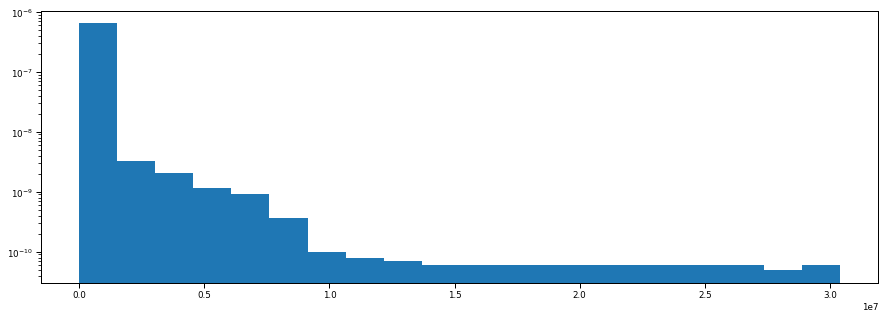

In [131]:
plt.hist(df['Confirmed'], density=True, bins=20) 
plt.yscale('log')

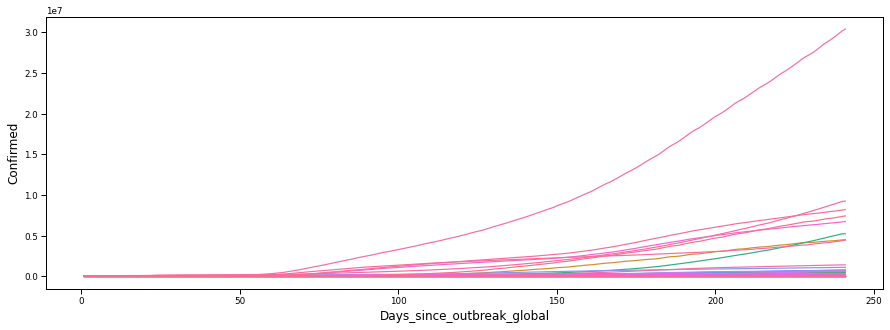

In [132]:
ax=sns.lineplot(data=df, hue="Country", x="Days_since_outbreak_global", y="Confirmed", ci=None)
ax.legend_.remove()

Days_since_outbreak_global  1    2    3    ...      239      240      241
Country                                    ...                           
Afghanistan                   0    0    0  ...    38855    38872    38883
Africa                        0    0    0  ...  1373765  1382370  1390511
Albania                       0    0    0  ...    11816    11948    12073
Algeria                       0    0    0  ...    48966    49194    49413
Andorra                       0    0    0  ...     1483     1483     1564

[5 rows x 241 columns]


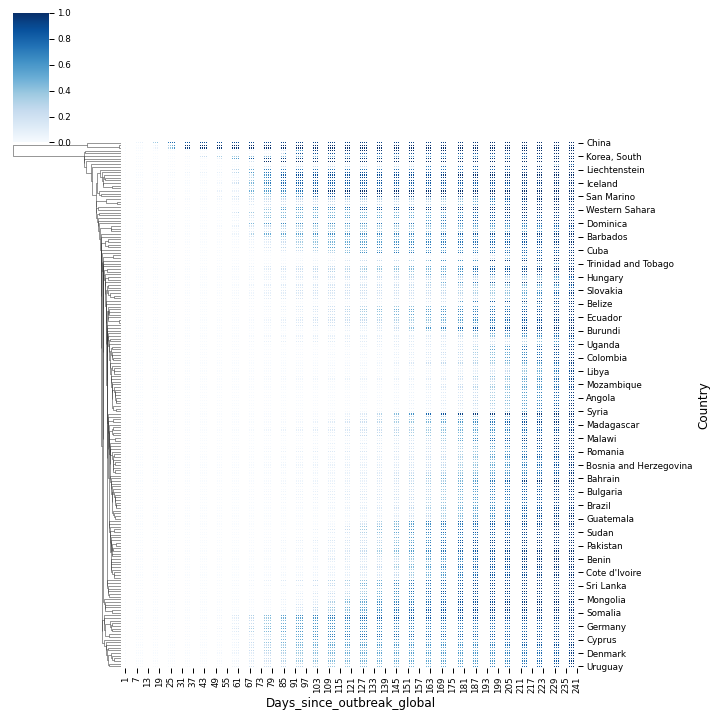

<Figure size 1800x576 with 0 Axes>

In [133]:
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":12,"axes.labelsize":12})   
def group_and_chart(Geography, Figure, Data):
    grouped = Data.groupby(['Days_since_outbreak_global',Geography])[Figure].sum()
    grouped= pd.DataFrame(grouped) 
    grouped.reset_index(inplace=True)
    grouped=grouped.pivot(index='Days_since_outbreak_global', columns=Geography, values=Figure)
    grouped = grouped.T[(grouped != 0).any()].T
    grouped = grouped.transpose()
    grouped.fillna(0, inplace=True)
    print(grouped.head())
    sns.clustermap(grouped, cmap="Blues", linewidth=.5, standard_scale=0,  col_cluster=False, method='single')
    plt.figure(figsize=(25,8))
    
group_and_chart(Geography='Country', Figure='Confirmed', Data=df)

Days_since_outbreak_global   1     2     3    ...      239      240      241
Continent                                     ...                           
Africa                         0     0     0  ...  1373765  1382370  1390511
Asia                        1102  1296  1857  ...  9065034  9193832  9225343
Europe                         0     0     2  ...  4277030  4332259  4393072
North America                  1     1     2  ...  8073864  8127845  8189269
Oceania                        0     0     0  ...    55983    56079    56129

[5 rows x 241 columns]


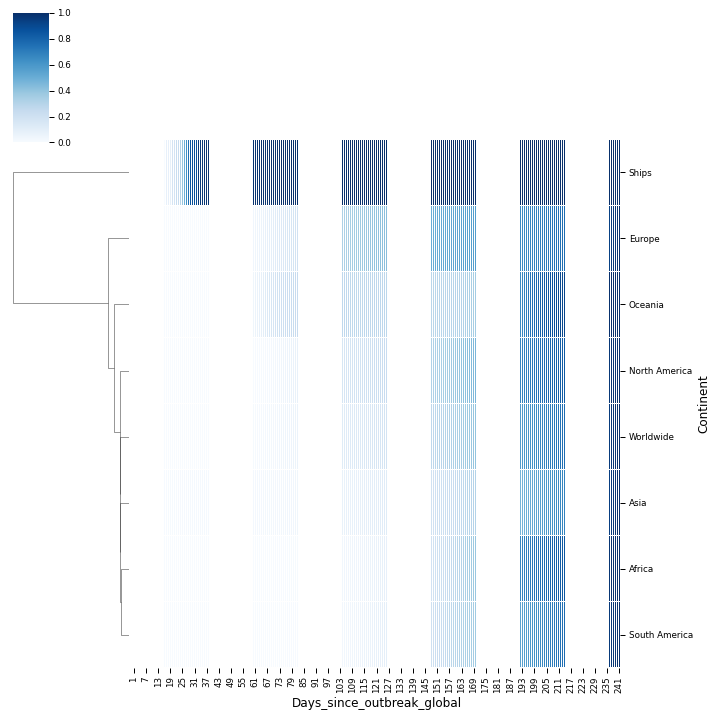

<Figure size 1800x576 with 0 Axes>

In [134]:
group_and_chart(Geography='Continent', Figure='Confirmed', Data=df)

Days_since_outbreak_global  1    2    3    4    ...     238     239     240     241
Country                                         ...                                
Afghanistan                   0    0    0    0  ...   38815   38855   38872   38883
Armenia                       0    0    0    0  ...   46119   46376   46671   46910
Azerbaijan                    0    0    0    0  ...   38517   38658   38777   38894
Bahrain                       0    0    0    0  ...   61643   62484   63189   63879
Bangladesh                    0    0    0    0  ...  341056  342671  344264  345805

[5 rows x 241 columns]


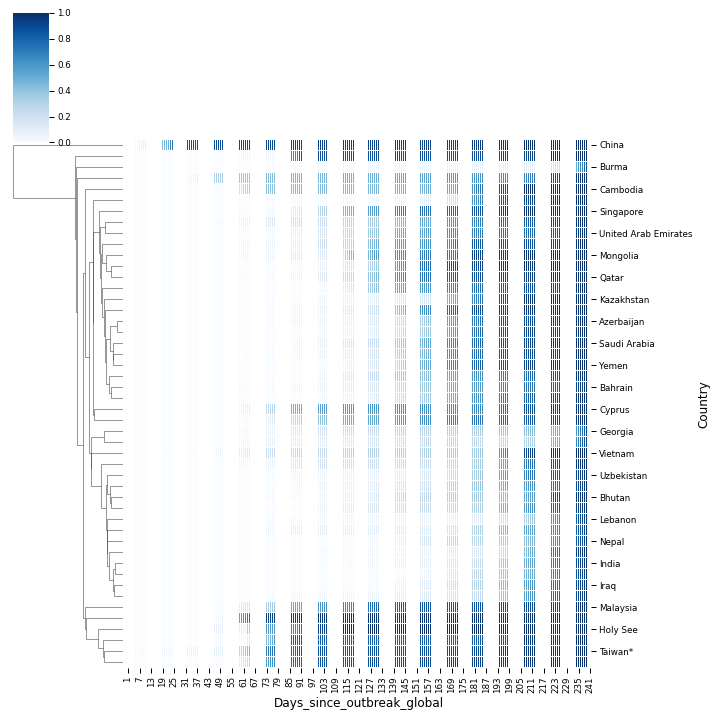

<Figure size 1800x576 with 0 Axes>

In [135]:
df_ = df.loc[(df.Continent == 'Asia')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1    2    3    4    ...    238    239    240    241
Country                                         ...                            
Albania                       0    0    0    0  ...  11672  11816  11948  12073
Andorra                       0    0    0    0  ...   1438   1483   1483   1564
Austria                       0    0    0    0  ...  34305  35073  35853  36661
Belarus                       0    0    0    0  ...  74552  74763  74987  75230
Belgium                       0    0    0    0  ...  94795  95948  97976  99649

[5 rows x 241 columns]


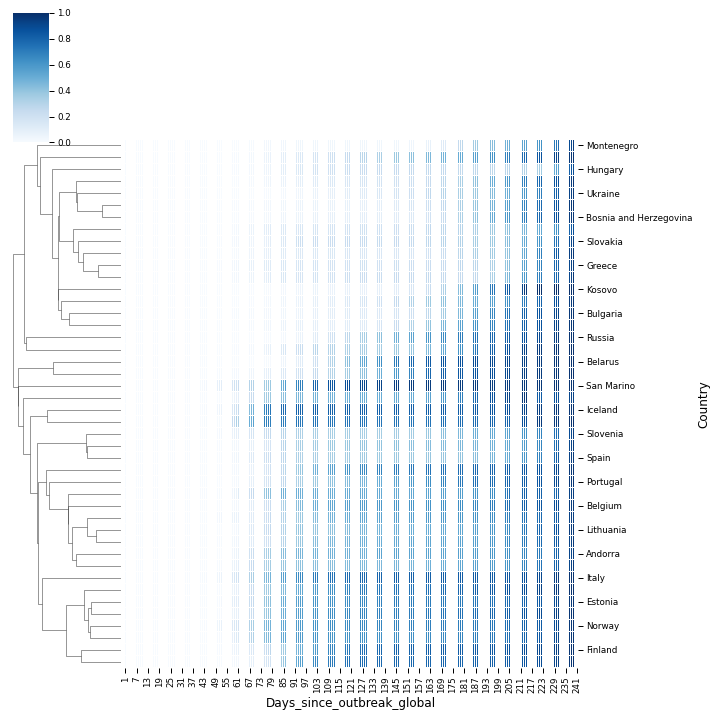

<Figure size 1800x576 with 0 Axes>

In [136]:
df_ = df.loc[(df.Continent == 'Europe')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1    2    3    4    ...    238    239    240    241
Country                                         ...                            
Algeria                       0    0    0    0  ...  48734  48966  49194  49413
Angola                        0    0    0    0  ...   3569   3675   3789   3848
Benin                         0    0    0    0  ...   2267   2280   2280   2280
Botswana                      0    0    0    0  ...   2463   2463   2567   2567
Burkina Faso                  0    0    0    0  ...   1733   1748   1767   1797

[5 rows x 241 columns]


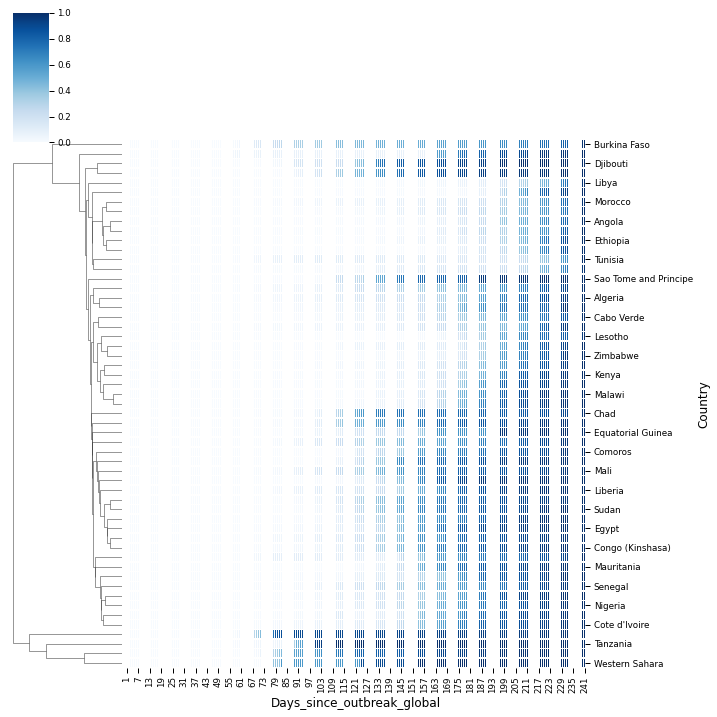

<Figure size 1800x576 with 0 Axes>

In [137]:
df_ = df.loc[(df.Continent == 'Africa')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1    2    3    4    ...     238     239     240     241
Country                                         ...                                
Antigua and Barbuda           0    0    0    0  ...      95      95      95      95
Bahamas                       0    0    0    0  ...    3032    3087    3177    3177
Barbados                      0    0    0    0  ...     184     185     185     185
Belize                        0    0    0    0  ...    1528    1536    1567    1590
Canada                        0    0    0    0  ...  281800  283704  285758  288106

[5 rows x 241 columns]


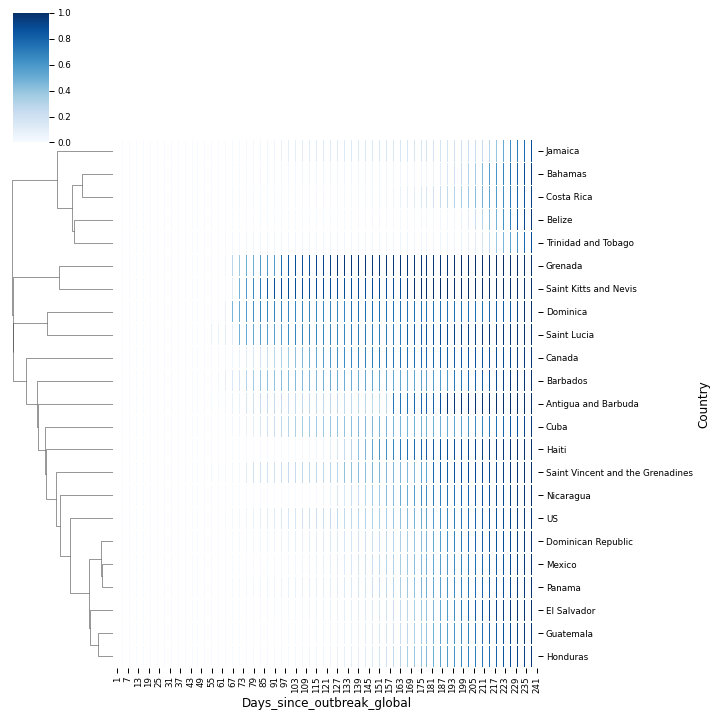

<Figure size 1800x576 with 0 Axes>

In [138]:
df_ = df.loc[(df.Continent == 'North America')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1    2    3    4    ...    238    239    240    241
Country                                         ...                            
Australia                     0    0    0    0  ...  53556  53626  53722  53770
Fiji                          0    0    0    0  ...     32     32     32     32
New Zealand                   0    0    0    0  ...   1802   1809   1809   1811
Papua New Guinea              0    0    0    0  ...    511    516    516    516

[4 rows x 241 columns]


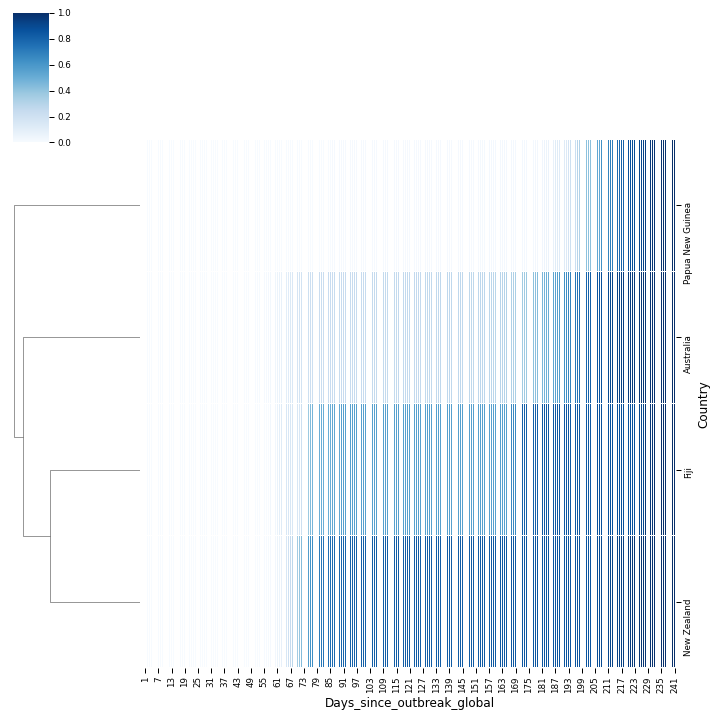

<Figure size 1800x576 with 0 Axes>

In [139]:
df_ = df.loc[(df.Continent == 'Oceania')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1    2    3    ...      239      240      241
Country                                    ...                           
Argentina                     0    0    0  ...   589012   601713   613658
Bolivia                       0    0    0  ...   128872   129419   130051
Brazil                        0    0    0  ...  4419083  4455386  4495183
Chile                         0    0    0  ...   439287   441150   442827
Colombia                      0    0    0  ...   736377   743945   750471

[5 rows x 241 columns]


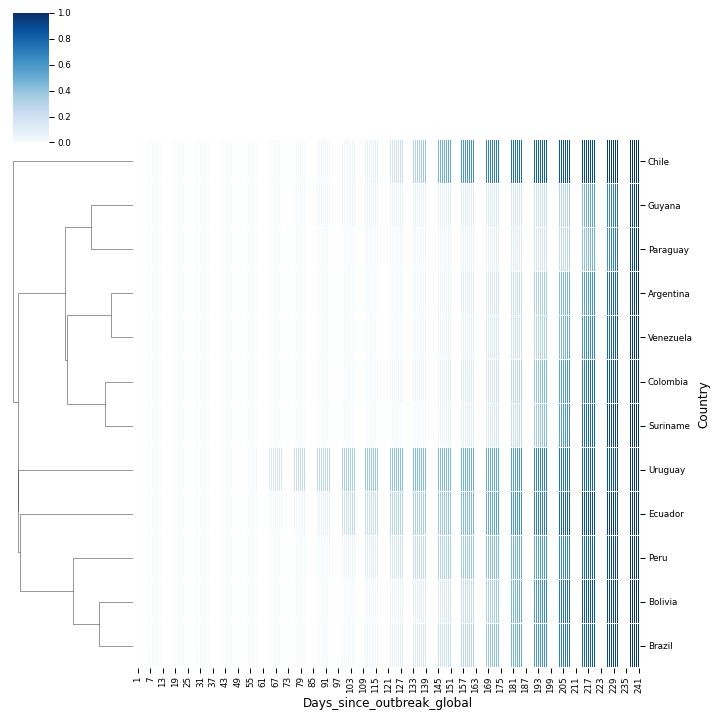

<Figure size 1800x576 with 0 Axes>

In [140]:
df_ = df.loc[(df.Continent == 'South America')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

## Analysis - daily increase

In [141]:
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df['Week_number'] = df['Date'].dt.week
df['Quarter'] = df['Date'].dt.quarter
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Confirmed_lag_1'] = df.groupby('Province_and_country')['Confirmed'].shift(1)
df['Daily_increase_confirmed'] = df['Confirmed']-df['Confirmed_lag_1']
df = df.replace([np.inf, -np.inf], np.nan)
#df.loc[df['Daily_increase_confirmed'] == np.inf, 'Daily_increase_confirmed'] = df['Confirmed']
#df.loc[df['Daily_increase_death'] == np.inf, 'Daily_increase_death'] = df['Deaths']
df = df.replace(np.nan, 0)
df

,Confirmed,Continent,Country,Country_Region,Date,Province,Province_and_country,iso2,Days_since_outbreak_global,Day,Weekday,Week_number,Quarter,Month,Year,Confirmed_lag_1,Daily_increase_confirmed
0,0,Asia,Afghanistan,Afghanistan,2020-01-22,0,Afghanistan,AF,1,22,2,4,1,1,2020,0.00,0.00
1,0,Europe,Albania,Albania,2020-01-22,0,Albania,AL,1,22,2,4,1,1,2020,0.00,0.00
2,0,Africa,Algeria,Algeria,2020-01-22,0,Algeria,DZ,1,22,2,4,1,1,2020,0.00,0.00
3,0,Europe,Andorra,Andorra,2020-01-22,0,Andorra,AD,1,22,2,4,1,1,2020,0.00,0.00
4,0,Africa,Angola,Angola,2020-01-22,0,Angola,AO,1,22,2,4,1,1,2020,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66752,4422737,0,Europe,0,2020-09-18,0,Europe,0,241,18,4,38,3,9,2020,4361664.00,61073.00
66753,8189269,0,North America,0,2020-09-18,0,North America,0,241,18,4,38,3,9,2020,8127845.00,61424.00
66754,56129,0,Oceania,0,2020-09-18,0,Oceania,0,241,18,4,38,3,9,2020,56079.00,50.00
66755,721,0,Ships,0,2020-09-18,0,Ships,0,241,18,4,38,3,9,2020,721.00,0.00


In [142]:
df.to_csv('df_m.CSV',sep=',')

Days_since_outbreak_global  1    2    3    4    ...     238     239     240     241
Country                                         ...                                
Afghanistan                0.00 0.00 0.00 0.00  ...   43.00   40.00   17.00   11.00
Africa                     0.00 0.00 0.00 0.00  ... 6563.00 7310.00 8605.00 8141.00
Albania                    0.00 0.00 0.00 0.00  ...  152.00  144.00  132.00  125.00
Algeria                    0.00 0.00 0.00 0.00  ...  238.00  232.00  228.00  219.00
Andorra                    0.00 0.00 0.00 0.00  ...    0.00   45.00    0.00   81.00

[5 rows x 241 columns]


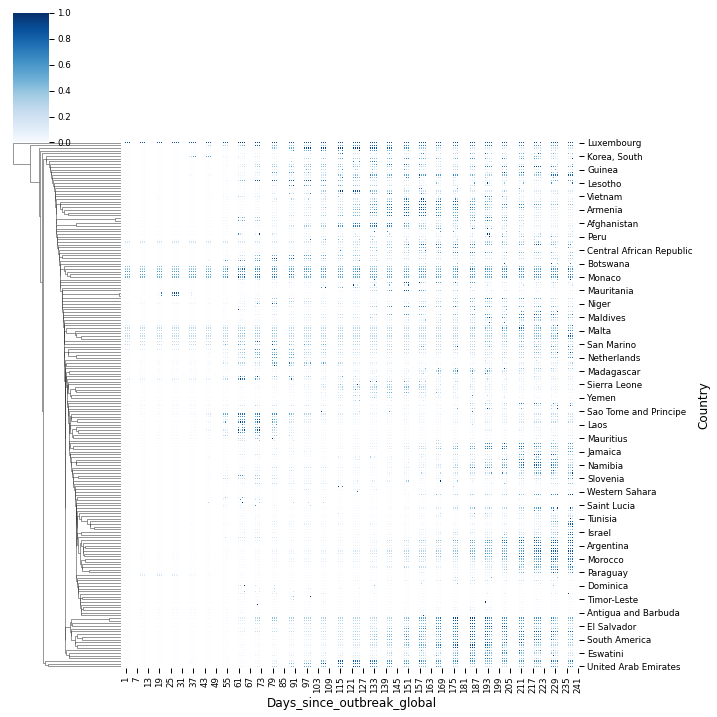

<Figure size 1800x576 with 0 Axes>

In [143]:
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df)

Days_since_outbreak_global  1      2      3    ...       239       240       241
Continent                                      ...                              
0                          0.00 194.00 564.00  ... 305701.00 314872.00 232359.00
Africa                     0.00   0.00   0.00  ...   7310.00   8605.00   8141.00
Asia                       0.00 194.00 561.00  ... 132237.00 128798.00  31511.00
Europe                     0.00   0.00   2.00  ...  50632.00  55229.00  60813.00
North America              0.00   0.00   1.00  ...  48517.00  53981.00  61424.00

[5 rows x 241 columns]


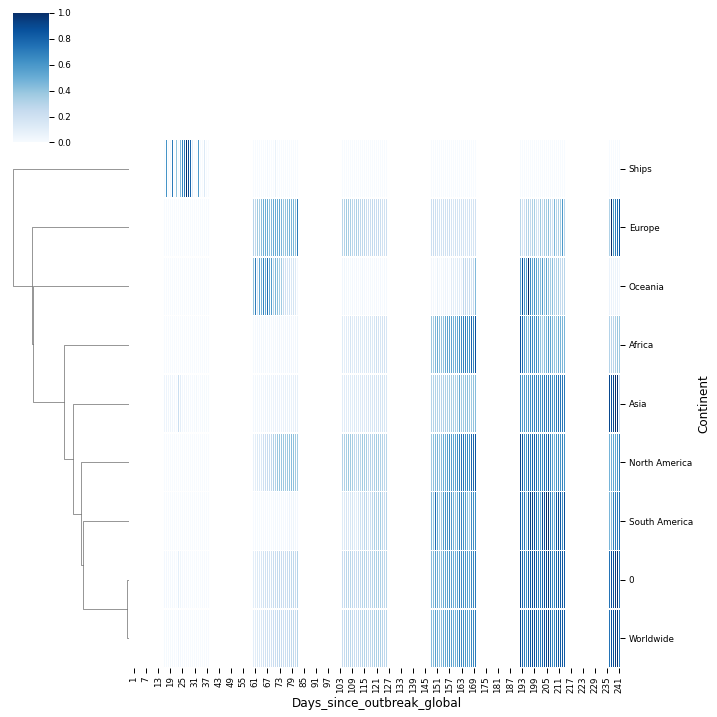

<Figure size 1800x576 with 0 Axes>

In [144]:
group_and_chart(Geography='Continent', Figure='Daily_increase_confirmed', Data=df)

Days_since_outbreak_global  1    2    3    4    ...     238     239     240     241
Country                                         ...                                
Afghanistan                0.00 0.00 0.00 0.00  ...   43.00   40.00   17.00   11.00
Armenia                    0.00 0.00 0.00 0.00  ...  150.00  257.00  295.00  239.00
Azerbaijan                 0.00 0.00 0.00 0.00  ...  114.00  141.00  119.00  117.00
Bahrain                    0.00 0.00 0.00 0.00  ...  678.00  841.00  705.00  690.00
Bangladesh                 0.00 0.00 0.00 0.00  ... 1724.00 1615.00 1593.00 1541.00

[5 rows x 241 columns]


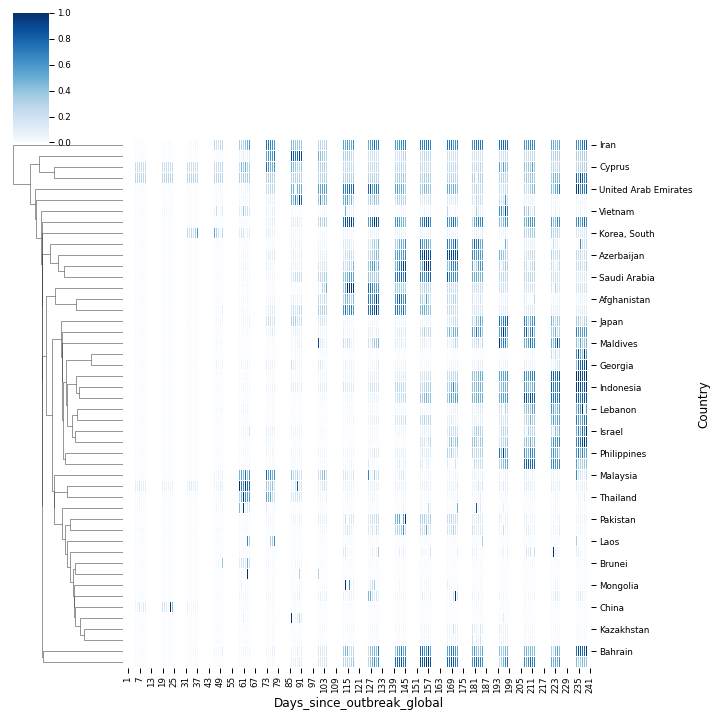

<Figure size 1800x576 with 0 Axes>

In [145]:
df_ = df.loc[(df.Continent == 'Asia')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global  1    2    3    4    ...    238     239     240     241
Country                                         ...                               
Albania                    0.00 0.00 0.00 0.00  ... 152.00  144.00  132.00  125.00
Andorra                    0.00 0.00 0.00 0.00  ...   0.00   45.00    0.00   81.00
Austria                    0.00 0.00 0.00 0.00  ... 764.00  768.00  780.00  808.00
Belarus                    0.00 0.00 0.00 0.00  ... 192.00  211.00  224.00  243.00
Belgium                    0.00 0.00 0.00 0.00  ... 489.00 1153.00 2028.00 1673.00

[5 rows x 241 columns]


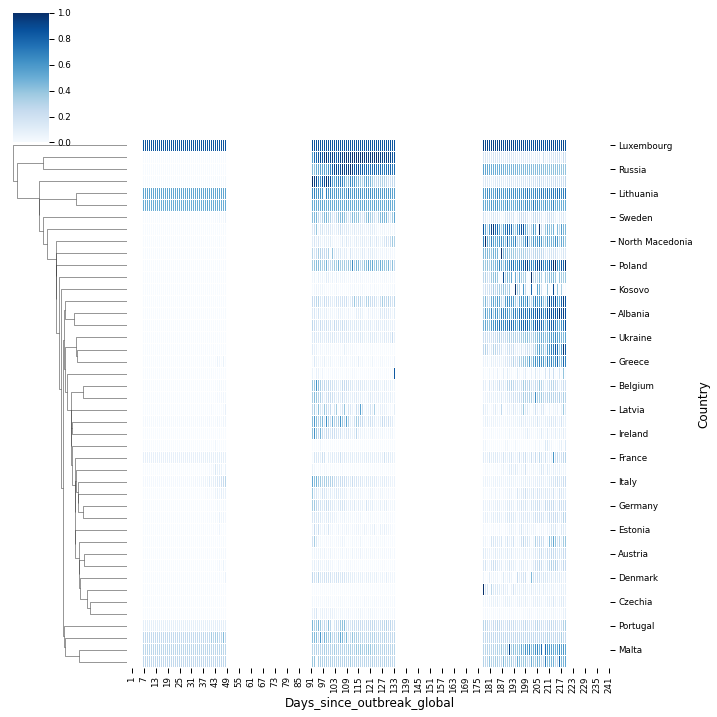

<Figure size 1800x576 with 0 Axes>

In [146]:
df_ = df.loc[(df.Continent == 'Europe')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global  1    2    3    4    ...    238    239    240    241
Country                                         ...                            
Algeria                    0.00 0.00 0.00 0.00  ... 238.00 232.00 228.00 219.00
Angola                     0.00 0.00 0.00 0.00  ... 130.00 106.00 114.00  59.00
Benin                      0.00 0.00 0.00 0.00  ...   0.00  13.00   0.00   0.00
Botswana                   0.00 0.00 0.00 0.00  ...   0.00   0.00 104.00   0.00
Burkina Faso               0.00 0.00 0.00 0.00  ...  16.00  15.00  19.00  30.00

[5 rows x 241 columns]


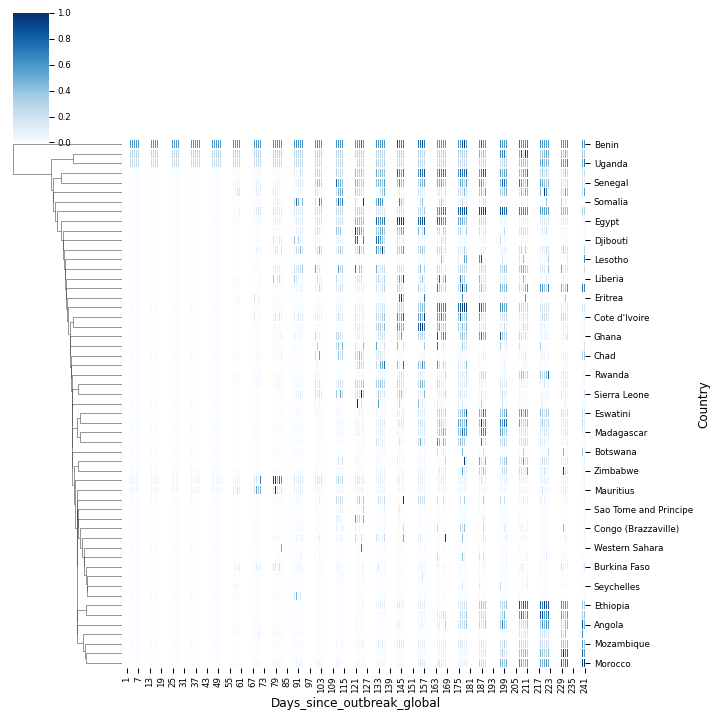

<Figure size 1800x576 with 0 Axes>

In [147]:
df_ = df.loc[(df.Continent == 'Africa')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global  1    2    3    4    ...     238     239     240     241
Country                                         ...                                
Antigua and Barbuda        0.00 0.00 0.00 0.00  ...    0.00    0.00    0.00    0.00
Bahamas                    0.00 0.00 0.00 0.00  ...   24.00   55.00   90.00    0.00
Barbados                   0.00 0.00 0.00 0.00  ...    1.00    1.00    0.00    0.00
Belize                     0.00 0.00 0.00 0.00  ...   27.00    8.00   31.00   23.00
Canada                     0.00 0.00 0.00 0.00  ... 1604.00 1904.00 2054.00 2348.00

[5 rows x 241 columns]


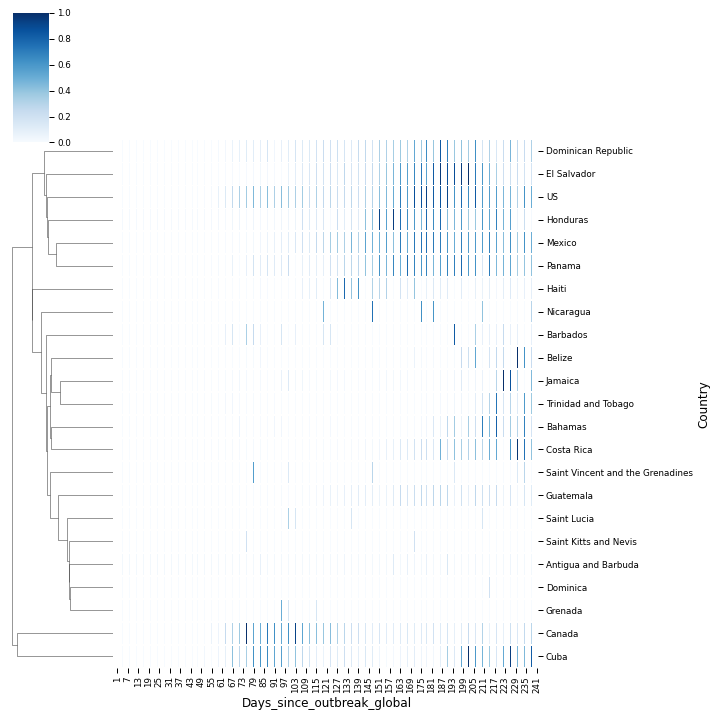

<Figure size 1800x576 with 0 Axes>

In [148]:
df_ = df.loc[(df.Continent == 'North America')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global  1    2    3    4    ...   238   239   240   241
Country                                         ...                        
Australia                  0.00 0.00 0.00 0.00  ... 78.00 70.00 96.00 48.00
Fiji                       0.00 0.00 0.00 0.00  ...  0.00  0.00  0.00  0.00
New Zealand                0.00 0.00 0.00 0.00  ...  1.00  7.00  0.00  2.00
Papua New Guinea           0.00 0.00 0.00 0.00  ...  0.00  5.00  0.00  0.00

[4 rows x 241 columns]


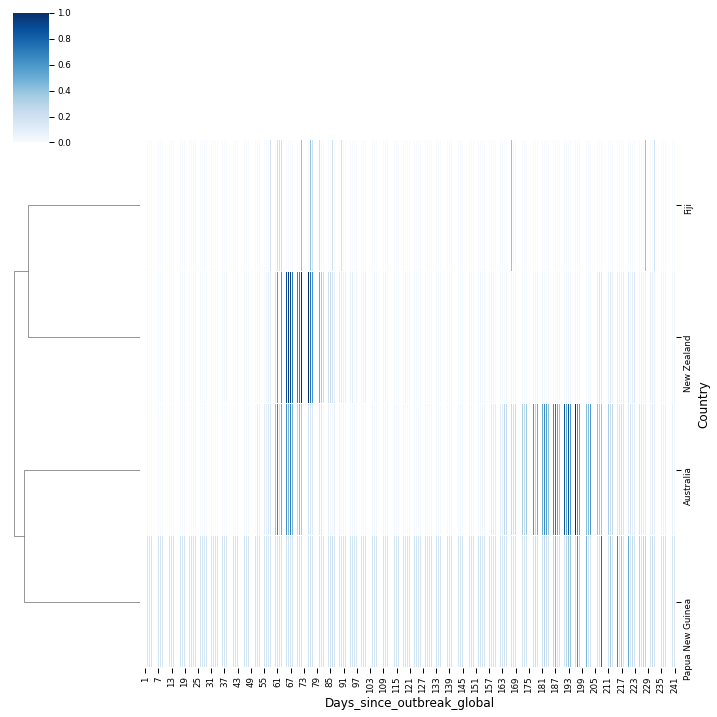

<Figure size 1800x576 with 0 Axes>

In [149]:
df_ = df.loc[(df.Continent == 'Oceania')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global  1    2    3    ...      239      240      241
Country                                    ...                           
Argentina                  0.00 0.00 0.00  ... 11674.00 12701.00 11945.00
Bolivia                    0.00 0.00 0.00  ...   586.00   547.00   632.00
Brazil                     0.00 0.00 0.00  ... 36820.00 36303.00 39797.00
Chile                      0.00 0.00 0.00  ...  1304.00  1863.00  1677.00
Colombia                   0.00 0.00 0.00  ...  7787.00  7568.00  6526.00

[5 rows x 241 columns]


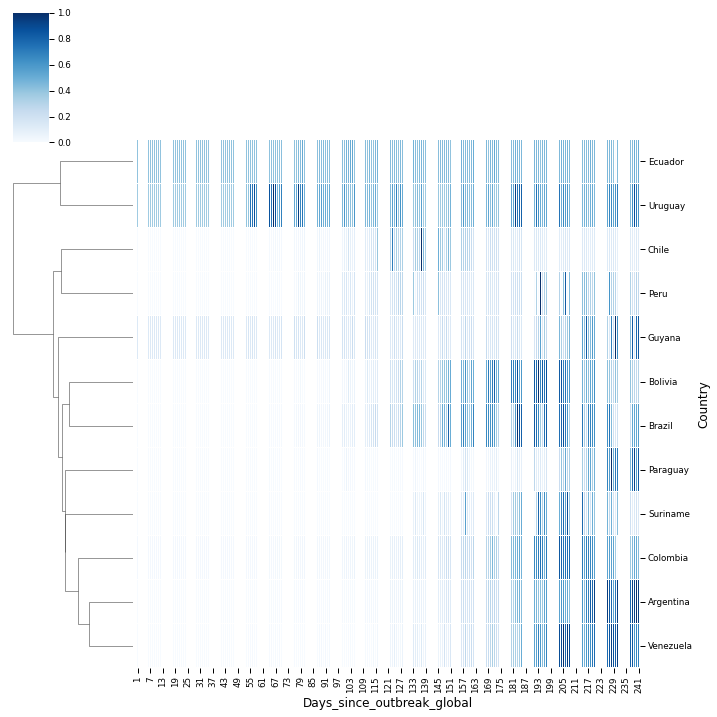

<Figure size 1800x576 with 0 Axes>

In [150]:
df_ = df.loc[(df.Continent == 'South America')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

## Prediction

In [152]:
df_ml_confirmed = df.copy()
df_ml_confirmed['Confirmed_lag_1'] = df_ml_confirmed.groupby('Province_and_country')['Confirmed'].shift(1)
df_ml_confirmed['Confirmed'] = df_ml_confirmed['Confirmed']-df_ml_confirmed['Confirmed_lag_1']
df_ml_confirmed['Confirmed_lag_7'] = df_ml_confirmed.groupby('Province_and_country')['Confirmed'].shift(7)
df_ml_confirmed['Days_since_outbreak_country'] = df_ml_confirmed.loc[(df_ml_confirmed.Confirmed.notnull())].groupby(['Province_and_country']).cumcount()+1
df_ml_confirmed = df_ml_confirmed.replace(np.nan, 0)
df_ml_confirmed = df_ml_confirmed[['Confirmed', 'Province_and_country', 'Days_since_outbreak_global', 'Date','Day','Weekday','Week_number','Quarter','Month','Year','Confirmed_lag_7','Days_since_outbreak_country']]

In [153]:
df_ml_confirmed.to_csv('df_ml.CSV',sep=',')

### One Country Test

In [154]:
split_date = datetime.today() - timedelta(days=8)
split_date

datetime.datetime(2020, 9, 11, 13, 6, 39, 128536)

In [155]:
def create_x_y(df, label=None):
    df.index = df['Date']
    X = df[['Days_since_outbreak_global','Day','Weekday','Week_number','Quarter','Month','Year', 'Confirmed_lag_7','Days_since_outbreak_country']]
    if label:
        y = df[label]
        return X, y
    return X

In [156]:
def root_mean_squared_log_error(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0: # check for negative values
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

27.883703846771304
34.21578272613992
0.3547760055361669


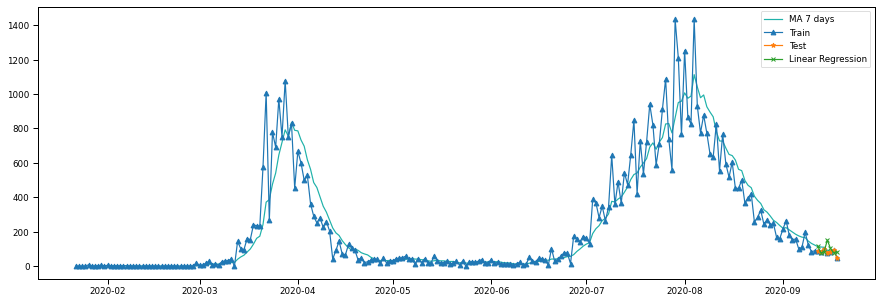

In [163]:
#Linear Regression
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Oceania")]
 
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[List.Date > split_date].copy()

X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class
linear_regressor.fit(X_train, y_train)

Confirmed_test['File_type'] = "Test"
Confirmed_train['File_type'] = "Train"

Confirmed_test['Confirmed_Prediction'] = linear_regressor.predict(X_test)
Combined = Confirmed_train.append(Confirmed_test)
Combined['MA_7_d'] = Combined['Confirmed'].rolling(window=7).mean()

plt.plot(Combined.index, Combined['MA_7_d'], label='MA 7 days', color = 'lightseagreen')
plt.plot(Combined.index, Combined['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Combined.index, Combined['Confirmed_Prediction'], label='Linear Regression', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction']))

394.18749989528857
448.8961440610886
0.3013191372736276


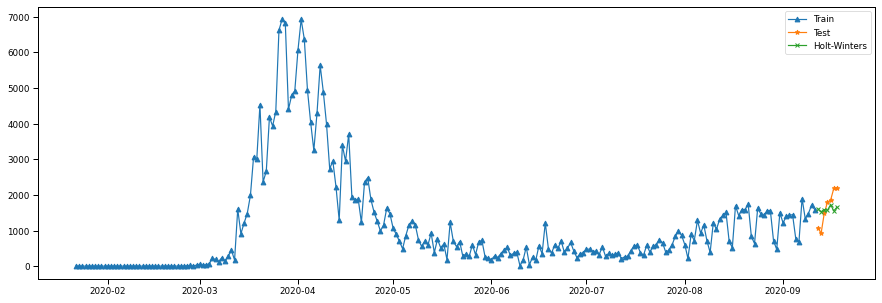

In [164]:
#Holt winters-non-optimized
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']
#List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12, damped=False) #base_model

hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

pred = hw_model.predict(start=test.index[0], end=test.index[-1])
pred = pd.DataFrame(pred)
pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Holt-Winters', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_squared_error(y_pred=pred, y_true=test)))
print(root_mean_squared_log_error(real=test.Confirmed, predicted=pred.Confirmed))

In [ ]:
#Holt Winters optimized
def exp_smoothing_configs():
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = [0,6,12]
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

cfg_list = exp_smoothing_configs()

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

best_RMSE = np.inf
best_config = []
t1 = d1 = s1 = p1 = b1 = r1 = ''
for j in range(len(cfg_list)):
    try:
        cg = cfg_list[j]
        t,d,s,p,b,r = cg

        model = ExponentialSmoothing(train, trend=t, damped=d, seasonal=s, seasonal_periods=p)

        hw_model = model.fit(optimized=True, use_boxcox=b, remove_bias=r)

        pred = hw_model.predict(start=test.index[0], end=test.index[-1])

        pred = pd.DataFrame(pred)
        pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)
        
        rmse = np.sqrt(mean_squared_error(y_pred=pred, y_true=test))
        
        if rmse < best_RMSE:
            best_RMSE = rmse
            best_config = cfg_list[j]
    except:
        continue

t1,d1,s1,p1,b1,r1 = best_config
print(best_config)

if t1 == None:
    model = ExponentialSmoothing(train, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    model = ExponentialSmoothing(train, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

hw_model = model.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

pred = hw_model.predict(start=test.index[0], end=test.index[-1])

pred = pd.DataFrame(pred)
pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Holt-Winters optimized', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_squared_error(y_pred=pred, y_true=test)))
print(root_mean_squared_log_error(real=test.Confirmed, predicted=pred.Confirmed))

In [ ]:
#Auto-Arima
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

stepwise_fit = auto_arima(train, error_action='ignore', trace=False,
                      suppress_warnings=True, seasonal=False, stepwise=True)  # set to stepwise

stepwise_fit.summary()

pred = pd.DataFrame(stepwise_fit.predict(n_periods=7), index= test.index)

pred.columns = ['Confirmed']

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Auto-Arima', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_squared_error(y_pred=pred, y_true=test)))
print(root_mean_squared_log_error(real=test.Confirmed, predicted=pred.Confirmed))

In [ ]:
#XGBoost non-optimized
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]
 
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[List.Date > split_date].copy()

X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

reg = xgb.XGBRegressor(n_estimators=1000, objective= 'reg:squarederror')
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=200,
       verbose=False) # Change verbose to True if you want to see it train

Confirmed_test['Confirmed_Prediction'] = reg.predict(X_test)

plt.plot(Confirmed_train.index, Confirmed_train['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed_Prediction'], label='XGBoost', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction']))

plot_importance(reg)
pyplot.show()

print(reg.get_xgb_params())

In [ ]:
#XGBoost Optimized
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 500,5000,500),
    }

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]
 
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[List.Date > split_date].copy()

X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

def hyperparameter_tuning(space):
    reg=xgb.XGBRegressor(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                         reg_alpha = int(space['reg_alpha']),min_child_weight=space['min_child_weight'],
                         colsample_bytree=space['colsample_bytree'], objective= 'reg:squarederror')
        
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric="rmse",
            early_stopping_rounds=200,verbose=False)

    pred = reg.predict(X_test)
    mae= mean_absolute_error(y_pred=pred, y_true=y_test)
    #change the metric if you like
    clear_output(wait=True)
    return {'loss':mae, 'status': STATUS_OK }

trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

reg = xgb.XGBRegressor(n_estimators =int(best['n_estimators']), max_depth = int(best['max_depth']), gamma = best['gamma'],
                         reg_alpha = int(best['reg_alpha']),min_child_weight=best['min_child_weight'],
                         colsample_bytree=best['colsample_bytree'], objective= 'reg:squarederror')
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=200,
       verbose=False) # Change verbose to True if you want to see it train

Confirmed_test['Confirmed_Prediction'] = reg.predict(X_test)

plt.plot(Confirmed_train.index, Confirmed_train['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed_Prediction'], label='XGBoost', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction']))

plot_importance(reg)
pyplot.show()

print(reg.get_xgb_params())

In [ ]:
#Catboost non-optimized
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]
 
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[List.Date > split_date].copy()

X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

model = CatBoostRegressor(iterations=1000, verbose=False, loss_function='RMSE')
# Fit model
model.fit(X_train, y_train,plot=True, eval_set=(X_test, y_test))

Confirmed_test['Confirmed_Prediction'] = model.predict(X_test)

plt.plot(Confirmed_train.index, Confirmed_train['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed_Prediction'], label='Catboost', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction']))

In [ ]:
#Prophet
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = train[['Confirmed','Date']]
test = test[['Confirmed','Date']]

model = Prophet()
model.fit(train.reset_index().rename(columns={'Date':'ds', 'Confirmed':'y'}))

#pred = model.predict(df=test.reset_index().rename(columns={'Date':'ds'}))
pred = pd.DataFrame(model.predict(df=test.reset_index().rename(columns={'Date':'ds'})))

#pd.DataFrame(stepwise_fit.predict(n_periods=7), index= Confirmed_test_.index)

test = test.reset_index(drop=True)
pred = pred.reset_index(drop=True)

plt.plot(train.Date, train.Confirmed, label='Train',marker ='^')
plt.plot(test.Date, test.Confirmed, label='Test', marker = "*")
plt.plot(test.Date, pred.yhat, label='Prophet', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred.yhat, y_true=test.Confirmed))
print(np.sqrt(mean_squared_error(y_pred=pred.yhat, y_true=test.Confirmed)))
print(root_mean_squared_log_error(real=test.Confirmed, predicted=pred.yhat))

fig = model.plot_components(pred)

### All customers

In [ ]:
df_ml_confirmed_var = pd.DataFrame(list(dict.fromkeys(df_ml_confirmed.Province_and_country)))
df_ml_confirmed_var.rename(columns={ df_ml_confirmed_var.columns[0]: "Value" }, inplace = True)
#df_ml_confirmed_var = df_ml_confirmed_var.loc[(df_ml_confirmed_var.Value == "Canada_Diamond Princess")]
#df_ml_confirmed_var = df_ml_confirmed_var.head(20)
len(df_ml_confirmed_var)

#### Linear Regression

In [ ]:
Train_and_Test = []

In [ ]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    Confirmed_train = List.loc[List.Date <= split_date].copy()
    Confirmed_test = List.loc[List.Date > split_date].copy()
    
    X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
    X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class

    linear_regressor.fit(X_train, y_train)

    Confirmed_test['Confirmed_Prediction'] = linear_regressor.predict(X_test)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Linear Regression"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Linear = pd.concat(Train_and_Test_temp)
Train_and_Test = pd.concat(Train_and_Test_temp)

In [ ]:
Train_and_Test_Linear = Train_and_Test_Linear.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.RMSLE.notnull(), 'RMSLE']))

#### Holt-Winters (non-optimized)

In [ ]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']
    
    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    model = ExponentialSmoothing(Confirmed_train_, trend='add', seasonal='add', seasonal_periods=12, damped=False) #base_model
    hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

    Confirmed_test['Confirmed_Prediction'] = hw_model.predict(start=Confirmed_test.index[0], end=Confirmed_test.index[-1])
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Holt-Winters Non-optimized"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Holt = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_Holt)

In [ ]:
Train_and_Test_Holt = Train_and_Test_Holt.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.RMSLE.notnull(), 'RMSLE']))

#### Holt-Winters (optimized)

In [ ]:
def exp_smoothing_configs(i):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = [0,6,12]
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

cfg_list = exp_smoothing_configs(i)

In [ ]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']
    
    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    best_RMSE = np.inf
    best_config = []
    t1 = d1 = s1 = p1 = b1 = r1 = ''
    for j in range(len(cfg_list)):
        try:
            cg = cfg_list[j]
            t,d,s,p,b,r = cg

            model = ExponentialSmoothing(Confirmed_train_, trend=t, damped=d, seasonal=s, seasonal_periods=p)

            hw_model = model.fit(optimized=True, use_boxcox=b, remove_bias=r)

            Confirmed_test['Confirmed_Prediction'] = hw_model.predict(start=Confirmed_test.index[0], end=Confirmed_test.index[-1])

            rmse = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))

            if rmse < best_RMSE:
                best_RMSE = rmse
                best_config = cfg_list[j]
        except:
            continue

    t1,d1,s1,p1,b1,r1 = best_config

    if t1 == None:
        model = ExponentialSmoothing(Confirmed_train_, trend=t1, seasonal=s1, seasonal_periods=p1)
    else:
        model = ExponentialSmoothing(Confirmed_train_, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

    hw_model = model.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

    Confirmed_test['Confirmed_Prediction'] = hw_model.predict(start=Confirmed_test.index[0], end=Confirmed_test.index[-1])
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Holt-Winters Optimized"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Holt_optimized = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_Holt_optimized)

In [ ]:
Train_and_Test_Holt_optimized = Train_and_Test_Holt_optimized.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Holt_optimized.loc[Train_and_Test_Holt_optimized.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Holt_optimized.loc[Train_and_Test_Holt_optimized.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Holt_optimized.loc[Train_and_Test_Holt_optimized.RMSLE.notnull(), 'RMSLE']))

#### Auto-ARIMA

In [ ]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']

    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    stepwise_fit = auto_arima(Confirmed_train_, error_action='ignore', trace=False,
                          suppress_warnings=True, seasonal=False, stepwise=True)  # set to stepwise

    stepwise_fit.summary()

    Confirmed_test['Confirmed_Prediction'] = pd.DataFrame(stepwise_fit.predict(n_periods=7), index= Confirmed_test_.index)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Auto-ARIMA"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_ARIMA = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_ARIMA)

In [ ]:
Train_and_Test_ARIMA = Train_and_Test_ARIMA.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.RMSLE.notnull(), 'RMSLE']))

#### XGboost (non-optimized)

In [ ]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    Confirmed_train = List.loc[List.Date <= split_date].copy()
    Confirmed_test = List.loc[List.Date > split_date].copy()
    
    X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
    X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    reg = xgb.XGBRegressor(n_estimators=1000, objective= 'reg:squarederror')
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            early_stopping_rounds=200,
           verbose=False) # Change verbose to True if you want to see it train

    Confirmed_test['Confirmed_Prediction'] = reg.predict(X_test)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = 'XGBoost (Non-optimized)'
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_XGBoost = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_XGBoost)

In [ ]:
Train_and_Test_XGBoost = Train_and_Test_XGBoost.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_XGBoost.loc[Train_and_Test_XGBoost.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_XGBoost.loc[Train_and_Test_XGBoost.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_XGBoost.loc[Train_and_Test_XGBoost.RMSLE.notnull(), 'RMSLE']))

#### XGboost (optimized)

In [ ]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    Confirmed_train = List.loc[List.Date <= split_date].copy()
    Confirmed_test = List.loc[List.Date > split_date].copy()
    
    X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
    X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    def hyperparameter_tuning(space):
        reg=xgb.XGBRegressor(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                             reg_alpha = int(space['reg_alpha']),min_child_weight=space['min_child_weight'],
                             colsample_bytree=space['colsample_bytree'], objective= 'reg:squarederror')

        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric="rmse",
                early_stopping_rounds=200,verbose=False)

        pred = reg.predict(X_test)
        mae= mean_absolute_error(y_pred=pred, y_true=y_test)
        #change the metric if you like
        clear_output(wait=True)
        return {'loss':mae, 'status': STATUS_OK }

    trials = Trials()
    best = fmin(fn=hyperparameter_tuning,
                space=space,
                algo=tpe.suggest,
                max_evals=100,
                trials=trials)

    reg = xgb.XGBRegressor(n_estimators =int(best['n_estimators']), max_depth = int(best['max_depth']), gamma = best['gamma'],
                             reg_alpha = int(best['reg_alpha']),min_child_weight=best['min_child_weight'],
                             colsample_bytree=best['colsample_bytree'], objective= 'reg:squarederror')
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            early_stopping_rounds=200,
           verbose=False) # Change verbose to True if you want to see it train

    Confirmed_test['Confirmed_Prediction'] = reg.predict(X_test)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = 'XGBoost (Optimized)'
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_XGBoost_optimized = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_XGBoost_optimized)

In [ ]:
Train_and_Test_XGBoost_optimized = Train_and_Test_XGBoost_optimized.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_XGBoost_optimized.loc[Train_and_Test_XGBoost_optimized.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_XGBoost_optimized.loc[Train_and_Test_XGBoost_optimized.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_XGBoost_optimized.loc[Train_and_Test_XGBoost_optimized.RMSLE.notnull(), 'RMSLE']))

#### CatBoost

In [ ]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    try:
    
        List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]

        Confirmed_train = List.loc[List.Date <= split_date].copy()
        Confirmed_test = List.loc[List.Date > split_date].copy()

        X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
        X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

        X_train = X_train.fillna(0)
        X_test = X_test.fillna(0)

        model = CatBoostRegressor(iterations=1000, verbose=False)
        model.fit(X_train, y_train)

        Confirmed_test['Confirmed_Prediction'] = model.predict(X_test)

        Confirmed_test['File_type'] = "Test"
        Confirmed_train['File_type'] = "Train"

        Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)

        Train_and_Test_['Model'] = 'CatBoost'

        Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

        Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))

        Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])

        Train_and_Test_temp.append(Train_and_Test_)
        
    except Exception as e: 
        pass
    
print("Finished!")

Train_and_Test_CatBoost = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_CatBoost)

In [ ]:
Train_and_Test_CatBoost = Train_and_Test_CatBoost.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_CatBoost.loc[Train_and_Test_CatBoost.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_CatBoost.loc[Train_and_Test_CatBoost.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_CatBoost.loc[Train_and_Test_CatBoost.RMSLE.notnull(), 'RMSLE']))

#### Prophet

In [ ]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']

    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)
    
    Confirmed_train_ = Confirmed_train[['Confirmed','Date']]
    Confirmed_test_ = Confirmed_test[['Confirmed','Date']]

    model = Prophet()
    model.fit(Confirmed_train_.reset_index(drop=True).rename(columns={'Date':'ds', 'Confirmed':'y'}))

    Confirmed_pred = model.predict(df=Confirmed_test_.reset_index(drop=True).rename(columns={'Date':'ds'}))
    
    Confirmed_test.index.name = None
    Confirmed_test = pd.merge(Confirmed_test, Confirmed_pred[['ds','yhat']], left_on='Date', right_on='ds', how='left').rename(columns={'yhat':'Confirmed_Prediction'}).drop(columns=['ds'])
            
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Prophet"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Prophet = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_Prophet)

In [ ]:
Train_and_Test_Prophet = Train_and_Test_Prophet.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Prophet.loc[Train_and_Test_Prophet.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Prophet.loc[Train_and_Test_Prophet.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Prophet.loc[Train_and_Test_Prophet.RMSLE.notnull(), 'RMSLE']))

#### Final Steps

In [ ]:
Train_and_Test['Update_date'] = datetime.today()

In [ ]:
print("forkin"+"me")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
Train_and_Test.to_excel('/content/drive/My Drive/Train_and_Test.xlsx', index = False)